### Program the basic algorithm

The DB scan algorithm is as follows:




DBSCAN(DB, dist, eps, minPts) {
   C = 0                                              /* Cluster counter */
   for each point P in database DB {
      if label(P) ≠ undefined then continue           /* Previously processed in inner loop */
      Neighbors N = RangeQuery(DB, dist, P, eps)      /* Find neighbors */
      if |N| < minPts then {                          /* Density check */
         label(P) = Noise                             /* Label as Noise */
         continue
      }
      C = C + 1                                       /* next cluster label */
      label(P) = C                                    /* Label initial point */
      Seed set S = N \ {P}                            /* Neighbors to expand */
      for each point Q in S {                         /* Process every seed point */
         if label(Q) = Noise then label(Q) = C        /* Change Noise to border point */
         if label(Q) ≠ undefined then continue        /* Previously processed */
         label(Q) = C                                 /* Label neighbor */
         Neighbors N = RangeQuery(DB, dist, Q, eps)   /* Find neighbors */
         if |N| ≥ minPts then {                       /* Density check */
            S = S ∪ N                                 /* Add new neighbors to seed set */
         }
      }
   }
}

RangeQuery(DB, dist, Q, eps) {
   Neighbors = empty list
   for each point P in database DB {                  /* Scan all points in the database */
      if dist(Q, P) ≤ eps then {                      /* Compute distance and check epsilon */
         Neighbors = Neighbors ∪ {P}                  /* Add to result */
      }
   }
   return Neighbors
}


Write a naive linear search version of the algorithm.
Time your solution, and test it on the basic distribution:

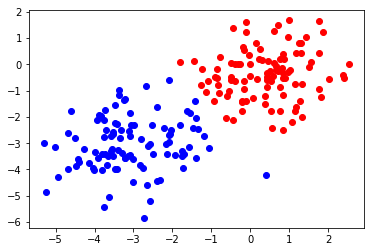

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from time import monotonic

#kmeans parameters:
#number of clusters:
k=2
#variance
var = 1
#generating distributions:
#first real mean, x axis
mean1x = 0.5
#first mean, y axis
mean1y = -0.5
#same for second means
mean2x = -3
mean2y = -3
num_points = 100

a = np.random.multivariate_normal([mean1x, mean1y], [[var, 0], [0, var]], size=num_points)
b = np.random.multivariate_normal([mean2x, mean2y], [[var, 0], [0, var]], size=num_points)

plt.plot(a[:,0], a[:,1],'ro')
plt.plot(b[:,0], b[:,1],'bo')
plt.show()

*** Running naive linear search - plotting every 100 iterations ***

iter = 0 - eps = 0.01 - min_pts = 1 - n. classes = 199 - n. noise = 0 - accuracy = 0%


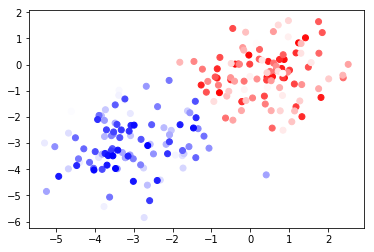

iter = 100 - eps = 0.77 - min_pts = 25 - n. classes = 2 - n. noise = 116 - accuracy = 42%


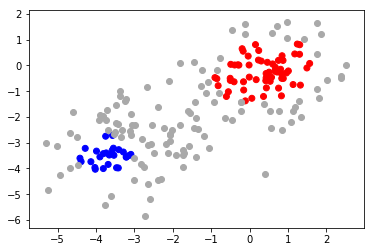

iter = 200 - eps = 1.49 - min_pts = 53 - n. classes = 2 - n. noise = 36 - accuracy = 80%


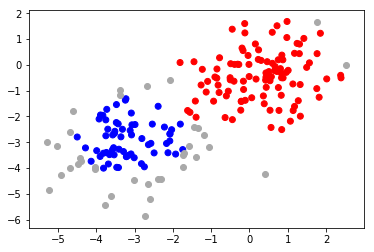

In [178]:
import math
def euclidian(point_a, point_b):
    return math.sqrt((point_a[0]-point_b[0])**2 + (point_a[1]-point_b[1])**2)
    
def range_query(db, dist, q_idx, eps):
    neighbors = []
    for idx, p in enumerate(db):
        if dist(db[idx], db[q_idx]) <= eps:
            neighbors.append(idx)
    return np.array(neighbors)

def dbscan(db, dist, eps, min_pts, range_q=range_query):
    c = 0
    labels = np.array([-1] * len(db))
    for idx, p in enumerate(db):
        if labels[idx] != -1:
            continue
        neighbors = range_q(db, dist, idx, eps)
        if len(neighbors) < min_pts:
            labels[idx] = 0
            continue
        c += 1
        labels[idx] = c
        s = [n for n in neighbors if n != idx]

        q_idx = 0
        while q_idx < len(s):
            q = s[q_idx]
            if labels[q] == 0:
                labels[q] = c
            elif labels[q] != -1:
                q_idx += 1
                continue
            labels[q] = c
            neighbors = range_q(db, dist, q_idx, eps)
            if len(neighbors) >= min_pts:
                for n in neighbors:
                    if n not in s:
                        s.append(n)
            q_idx += 1
    
    return labels

def plot_clusters(c_classes, labels, c_noise):
    plt.scatter(c_classes[:,0], c_classes[:,1], c=labels[np.where(labels>0)], cmap='bwr_r')
    plt.scatter(c_noise[:,0], c_noise[:,1], color='darkgrey')
    plt.show()

def linear_search(a, b, n_iters, eps_step = 0.1, min_pts_step = 1, range_q=range_query):
    eps = eps_step
    min_pts = min_pts_step
    n_noise = 0
    n_classes = 0
    
    best_eps = 0
    best_min_pts = 0
    best_accuracy = 0
    
    for i in range(n_iters):
        c = np.concatenate((a,b), axis=0)
        labels = dbscan(c, euclidian, eps, min_pts, range_q)
        c_classes = c[np.where(labels>0)]
        c_noise = c[np.where(labels==0)]

        n_noise = len(c_noise)
        n_classes = len(np.unique(labels[labels>0]))
        accuracy1 = (len(np.where(labels[:len(a)]==1)[0]) + len(np.where(labels[len(a):len(c)]==2)[0])) / len(c)
        accuracy2 = (len(np.where(labels[:len(a)]==2)[0]) + len(np.where(labels[len(a):len(c)]==1)[0])) / len(c)
        accuracy = max(accuracy1, accuracy2)
        
        # Exit if all points in the same class
        if n_classes == 1 and n_noise == 0:
            break

        if i % 100 == 0:
            print('iter = %d - eps = %.2f - min_pts = %d - n. classes = %d - n. noise = %d - accuracy = %d%%' % 
                  (i, eps, min_pts, n_classes, n_noise, accuracy*100))
            plot_clusters(c_classes, labels, c_noise)
        
        if accuracy > best_accuracy and n_classes == 2:
            best_eps = eps
            best_min_pts = min_pts
            best_accuracy = accuracy
        
        if n_classes > 2:
            min_pts += min_pts_step
        else:
            eps += eps_step
            
    return best_eps, best_min_pts, best_accuracy

print('*** Running naive linear search - plotting every 100 iterations ***\n')

start_time = monotonic()
eps, min_pts, accuracy = linear_search(a, b, 1000, 0.01, 1)
dbscan_rangeq_run_time = monotonic() - start_time

Optimizing the DBSCAN/RangeQuery algo via Naive Linear Search took 28 seconds
Eps = 1.89 - Min pts = 69 - Accuracy = 88%


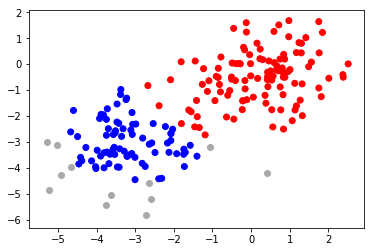

In [179]:
print('Optimizing the DBSCAN/RangeQuery algo via Naive Linear Search took %d seconds' % dbscan_rangeq_run_time)
print('Eps = %.2f - Min pts = %d - Accuracy = %d%%' % (eps, min_pts, (accuracy*100)))

c = np.concatenate((a,b), axis=0)
labels = dbscan(c, euclidian, eps, min_pts)
c_classes = c[np.where(labels>0)]
c_noise = c[np.where(labels==0)]

plot_clusters(c_classes, labels, c_noise)

Now, implement RangeQuery() it using R* tree. Do you see any significant runtime difference?

iter = 0 - eps = 0.01 - min_pts = 1 - n. classes = 199 - n. noise = 0 - accuracy = 0%


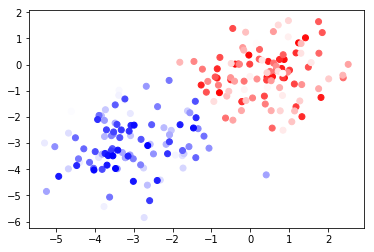

iter = 100 - eps = 0.74 - min_pts = 28 - n. classes = 3 - n. noise = 99 - accuracy = 41%


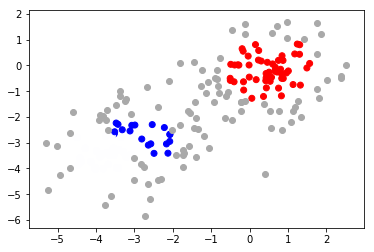

iter = 200 - eps = 1.45 - min_pts = 57 - n. classes = 2 - n. noise = 22 - accuracy = 83%


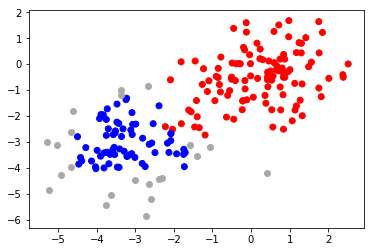

In [180]:
from rtree import index
from rtree.index import Rtree

# Create the R-Tree index and add all points inside
idx = index.Index()
for i, point in enumerate(c):
    idx.insert(i, (point[0], point[1], point[0], point[1]))

def rtree_range_query(db, dist, q_idx, eps):
    # Keep the dist parameter for compatibility with db scan algo
    q = db[q_idx]
    return list(idx.intersection((q[0]-eps, q[1]-eps, q[0]+eps, q[1]+eps)))

start_time = monotonic()
eps, min_pts, accuracy = linear_search(a, b, 1000, 0.01, 1, rtree_range_query)
dbscan_rtree_run_time = monotonic() - start_time

Optimizing the DBSCAN/R-Tree algo via Naive Linear Search took 4 seconds
Eps = 1.42 - Min pts = 57 - Accuracy = 84%


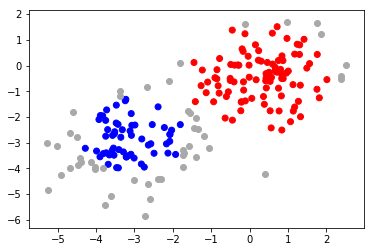

In [181]:
print('Optimizing the DBSCAN/R-Tree algo via Naive Linear Search took %d seconds' % dbscan_rtree_run_time)
print('Eps = %.2f - Min pts = %d - Accuracy = %d%%' % (eps, min_pts, (accuracy*100)))

c = np.concatenate((a,b), axis=0)
labels = dbscan(c, euclidian, eps, min_pts)
c_classes = c[np.where(labels>0)]
c_noise = c[np.where(labels==0)]

plot_clusters(c_classes, labels, c_noise)

In [182]:
print('Running DBScan with R-Tree took %.2f less time to converge than with RangeQuery!!!' % (dbscan_rangeq_run_time/dbscan_rtree_run_time ))


Running DBScan with R-Tree took 6.32 less time to converge than with RangeQuery!!!
